In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
data = pd.read_csv("data/processed/fraud.csv")

X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P'].astype(int)

# Split 
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 9252, Val: 3084, Test: 3084


In [3]:
# Pipeline with SMOTEENN
lgb_clf = lgb.LGBMClassifier(random_state=42, n_estimators=500, verbose=-1)

baseline_model = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('lgb', lgb_clf)
])


In [4]:
# Stratified 5-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# CV on training set
cv_scores = cross_val_score(baseline_model , X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)
print("Baseline CV F1-mean:", cv_scores.mean())
print("Baseline CV F1-std:", cv_scores.std())


Baseline CV F1-mean: 0.5084782859838457
Baseline CV F1-std: 0.03170265215727475


In [5]:
# Fit on full training data
baseline_model .fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = baseline_model .predict(X_val)
y_val_prob = baseline_model .predict_proba(X_val)[:, 1]

print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2900
           1       0.51      0.55      0.53       184

    accuracy                           0.94      3084
   macro avg       0.74      0.76      0.75      3084
weighted avg       0.94      0.94      0.94      3084

Validation ROC-AUC: 0.9370670914542729
Validation Confusion Matrix:
 [[2803   97]
 [  83  101]]


Number of selected features: 21
Number of dropped features: 23
Selected features: ['PolicyNumber', 'Age', 'RepNumber', 'Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'AgeVehicleRatio', 'Make_label_encoded', 'WeekOfMonth', 'DriverRating', 'Make_frequency_encoded', 'NumberOfSuppliments', 'WeekOfMonthClaimed', 'VehiclePrice', 'PastNumberOfClaims', 'BasePolicy', 'AgeOfVehicle', 'AddressChange_Claim', 'Fault', 'Deductible']
Dropped features: ['AccidentArea', 'Sex', 'MaritalStatus', 'VehicleCategory', 'Days_Policy_Accident', 'Days_Policy_Claim', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfCars', 'Year', 'DaysToClaimRatio', 'IsYoungDriver', 'IsOldVehicle', 'QuickClaim', 'NoPoliceReport', 'NoWitness', 'IsNewPolicy', 'HighDeductible', 'IsFrequentClaimant', 'AddressChanged', 'RiskScore']


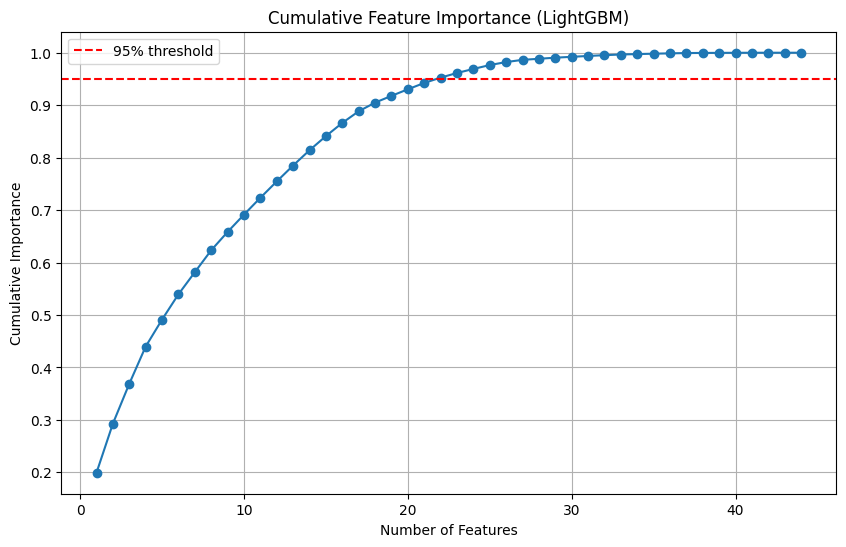

In [6]:
# Feature selection
lgb_clf_fs = lgb.LGBMClassifier(random_state=42, n_estimators=500, verbose=-1)
lgb_clf_fs.fit(X_train, y_train)

importances = pd.Series(lgb_clf_fs.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)
cumulative_importance = importances_sorted.cumsum() / importances_sorted.sum()

selected_features = cumulative_importance[cumulative_importance <= 0.95].index.tolist()
dropped_features = [f for f in X_train.columns if f not in selected_features]

print(f"Number of selected features: {len(selected_features)}")
print(f"Number of dropped features: {len(dropped_features)}")
print("Selected features:", selected_features)
print("Dropped features:", dropped_features)

plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_importance)+1), cumulative_importance.values, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.title("Cumulative Feature Importance (LightGBM)")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Use selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

print("X_train shape after feature selection:", X_train_selected.shape)
print("X_val shape after feature selection:", X_val_selected.shape)

X_train shape after feature selection: (9252, 21)
X_val shape after feature selection: (3084, 21)


In [8]:
baseline_model.fit(X_train_selected, y_train)
y_val_pred_fs = baseline_model.predict(X_val_selected)
y_val_prob_fs = baseline_model.predict_proba(X_val_selected)[:, 1]

print("Feature Selection Classification Report:")
print(classification_report(y_val, y_val_pred_fs))
print("Feature Selection Validation ROC-AUC:", roc_auc_score(y_val, y_val_prob_fs))
print("Feature Selection Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_fs))

Feature Selection Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2900
           1       0.52      0.57      0.54       184

    accuracy                           0.94      3084
   macro avg       0.74      0.77      0.76      3084
weighted avg       0.95      0.94      0.94      3084

Feature Selection Validation ROC-AUC: 0.9482496251874063
Feature Selection Validation Confusion Matrix:
 [[2802   98]
 [  79  105]]


In [9]:
# Define hyperparameter grid
param_grid = {
    'lgb__n_estimators': [100, 200, 500],
    'lgb__learning_rate': [0.01, 0.05, 0.1],
    'lgb__num_leaves': [31, 50, 70],
    'lgb__max_depth': [5, 10, -1],
    'lgb__min_child_samples': [10, 20, 50]
}

# Grid search
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator= baseline_model,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_selected, y_train)

best_model = grid_search.best_estimator_

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Best hyperparameters: {'lgb__learning_rate': 0.1, 'lgb__max_depth': -1, 'lgb__min_child_samples': 50, 'lgb__n_estimators': 500, 'lgb__num_leaves': 31}
Best CV F1: 0.51808014217224


In [10]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score

# Evaluate tuned model on validation
y_val_pred_tuned = best_model.predict(X_val_selected)
y_val_prob_tuned = best_model.predict_proba(X_val_selected)[:, 1]

print("Classification Report:") 
print(classification_report(y_val, y_val_pred_tuned, digits=4))

roc_auc = roc_auc_score(y_val, y_val_prob_tuned)
pr_auc = average_precision_score(y_val, y_val_prob_tuned)

print("Tuned Validation ROC-AUC:", roc_auc)
print("Tuned Validation PR-AUC:", pr_auc)
print("Tuned Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_tuned))


Classification Report:
              precision    recall  f1-score   support

           0     0.9710    0.9597    0.9653      2900
           1     0.4633    0.5489    0.5025       184

    accuracy                         0.9351      3084
   macro avg     0.7172    0.7543    0.7339      3084
weighted avg     0.9407    0.9351    0.9377      3084

Tuned Validation ROC-AUC: 0.9361019490254873
Tuned Validation PR-AUC: 0.48794982264639963
Tuned Validation Confusion Matrix:
 [[2783  117]
 [  83  101]]


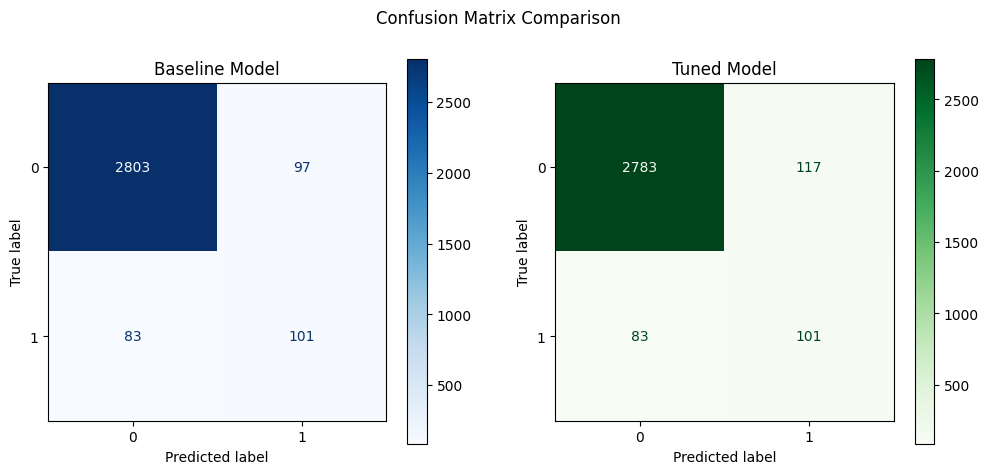

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrices
cm_baseline = confusion_matrix(y_val, y_val_pred)
cm_tuned = confusion_matrix(y_val, y_val_pred_tuned)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline
disp = ConfusionMatrixDisplay(cm_baseline, display_labels=[0,1])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Baseline Model')

# Tuned
disp = ConfusionMatrixDisplay(cm_tuned, display_labels=[0,1])
disp.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Tuned Model')

plt.suptitle("Confusion Matrix Comparison")
plt.show()


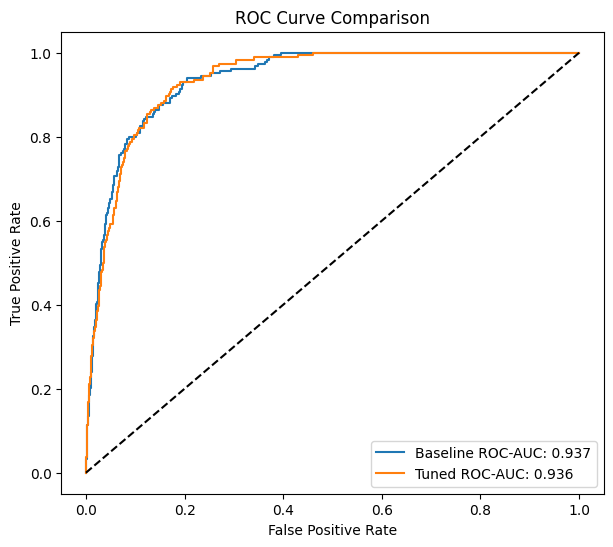

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC
fpr_base, tpr_base, _ = roc_curve(y_val, y_val_prob)
fpr_tuned, tpr_tuned, _ = roc_curve(y_val, y_val_prob_tuned)

plt.figure(figsize=(7,6))
plt.plot(fpr_base, tpr_base, label=f'Baseline ROC-AUC: {roc_auc_score(y_val, y_val_prob):.3f}')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned ROC-AUC: {roc_auc_score(y_val, y_val_prob_tuned):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


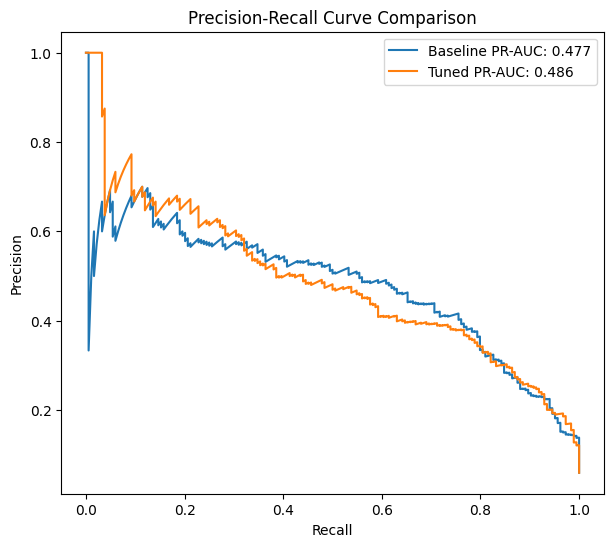

In [13]:
from sklearn.metrics import precision_recall_curve, auc

# Compute PR curves
precision_base, recall_base, _ = precision_recall_curve(y_val, y_val_prob)
pr_auc_base = auc(recall_base, precision_base)

precision_tuned, recall_tuned, _ = precision_recall_curve(y_val, y_val_prob_tuned)
pr_auc_tuned = auc(recall_tuned, precision_tuned)

plt.figure(figsize=(7,6))
plt.plot(recall_base, precision_base, label=f'Baseline PR-AUC: {pr_auc_base:.3f}')
plt.plot(recall_tuned, precision_tuned, label=f'Tuned PR-AUC: {pr_auc_tuned:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()



Validation Metrics Comparison:
      Model  Accuracy  Recall  F1-score  ROC-AUC  PR-AUC
0  Baseline    0.9416  0.5489    0.5288   0.9371  0.4767
1     Tuned    0.9351  0.5489    0.5025   0.9361  0.4859


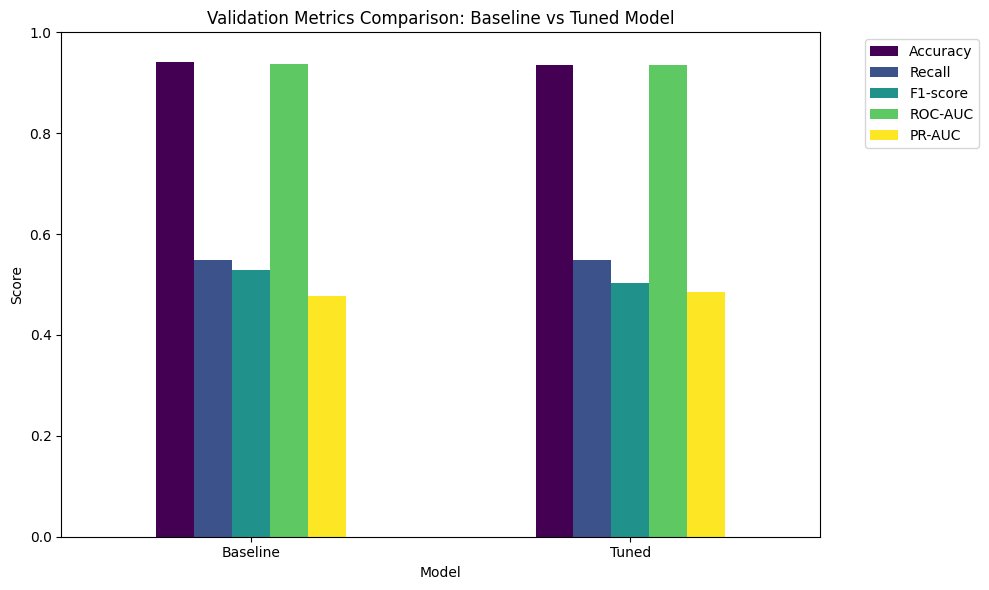

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_recall_curve, auc,
    recall_score, accuracy_score
)

# Baseline model metrics 
f1_base = f1_score(y_val, y_val_pred)
roc_base = roc_auc_score(y_val, y_val_prob)
recall_base = recall_score(y_val, y_val_pred)
acc_base = accuracy_score(y_val, y_val_pred)
precision_base, recall_curve_base, _ = precision_recall_curve(y_val, y_val_prob)
pr_auc_base = auc(recall_curve_base, precision_base)

# Tuned model metrics 
f1_tuned = f1_score(y_val, y_val_pred_tuned)
roc_tuned = roc_auc_score(y_val, y_val_prob_tuned)
recall_tuned = recall_score(y_val, y_val_pred_tuned)
acc_tuned = accuracy_score(y_val, y_val_pred_tuned)
precision_tuned, recall_curve_tuned, _ = precision_recall_curve(y_val, y_val_prob_tuned)
pr_auc_tuned = auc(recall_curve_tuned, precision_tuned)

summary_df = pd.DataFrame({
    "Model": ["Baseline", "Tuned"],
    "Accuracy": [acc_base, acc_tuned],
    "Recall": [recall_base, recall_tuned],
    "F1-score": [f1_base, f1_tuned],
    "ROC-AUC": [roc_base, roc_tuned],
    "PR-AUC": [pr_auc_base, pr_auc_tuned]
})

print("\nValidation Metrics Comparison:")
print(summary_df.round(4))

summary_df.set_index("Model").plot(kind='bar', figsize=(10,6), colormap='viridis')

plt.title("Validation Metrics Comparison: Baseline vs Tuned Model")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
